# Problem komiwojażera

Nazwa pochodzi od typowej ilustracji problemu, przedstawiającej go z punktu widzenia wędrownego sprzedawcy (komiwojażera): dane jest $n$ miast, które komiwojażer ma odwiedzić, oraz odległość pomiędzy każdą parą miast. Celem jest znalezienie jak najkrótszej drogi łączącej wszystkie miasta, zaczynającej się i kończącej się w określonym, tym samym punkcie.
	
W wersji decyzyjnej problemu, danymi są graf i pewna liczba $n$, należy odpowiedzieć czy istnieje trasa komiwojażera krótsza od $n$.
	
Tak sformułowany problem jest **NP-zupełny**.
	
Celem mojego projektu było znalezienie jak najkrótszej trasy pomiędzy miastami przy liczbie $m$ dostępnych aut - nie wszystkie z nich musiały być wykorzystane.

Wprowadzenie paczek, z których będziemy korzystać:

In [28]:
import pygad
import numpy as np
import pandas as pd
import time
import math
import random
import matplotlib.pyplot as plt
import warnings

Definiujemy funkcję obliczającą odległości między miastami - metryka euklidesowa:

$$d(A,B) = \sqrt{(x_{A} - x_{B})^2 + (y_{A} - y_{B})^2}$$

In [29]:
def odleglosc(A,B):
    return math.sqrt((A[0] - B[0])**2 + (A[1] - B[1])**2) 

# Rozwiązanie za pomocą algorytmu genetycznego

Definiujemy funkcje fitness, zliczającą sumę odległości pomiędzy miastami odrębnie dla każdego auta. Chcemy ją zminimalizować, dlatego zwracamy ją z minusem. Czyli przypisujemy miasta i ich kolejność samochodom.

In [3]:
def fitness_func(solution, solution_idx):
    #zliczamy sumę odległości pomiędzy miastami dla każdego auta
    #na początku ustawiamy sumę na 0
    suma_odleglosci = 0
    #for dla każdego auta
    for j in range(auta):
        #ustawiamy miasto początkowe na to o indexie 0
        Miasto1 = Miasta[0]
        #poruszamy się po chromosomie w przedziale odpowiedznim dla każdego auta
        for i in range((miasta-1) * j,(miasta-1) * (j+1)):
            #if sprawdzający czy istnieje takie miasto jak wartość w chromosomie
            if solution[i] < miasta:
                    index2 = int(solution[i])
                    Miasto2 = Miasta[index2]
                    suma_odleglosci += odleglosc(Miasto1, Miasto2)
                    Miasto1 = Miasto2
        suma_odleglosci += odleglosc(Miasta[0],Miasto1)
    return -suma_odleglosci

Definiujemy własną funkcję PMX, aby krzyżować chromosomy

Algorytm:

1. Randomowo wybieramy część z rodzica 1 i kopiujemy je bezpośrednio do dziecka zachowując kolejność oraz indeksy,

2. Po kolei przepisujemy wartości z rodzica 2 do dziecka jednocześnie upewniając się czy dana wartość nie występuje już w naszym chromosomie dziecka,

    - Jeśli nie to przepisujemy,
    
    - Jeśli tak to:
    
         1. Sprawdzamy indeks występowania danej liczby w rodzicu 1 zastępuję ją liczbą z pozycji odpowiadającej danemu indeksowi z rodzica 2, jak nie mam to wpisuje,
         
         2. Jeśli przypisana liczba już jest w naszym fragmencie w dziecku, to wracam do podpunktu A. Sprawdzam indeks i przypisuje odpowiadającą mu liczbę,


https://www.rubicite.com/Tutorials/GeneticAlgorithms/CrossoverOperators/PMXCrossoverOperator.aspx

https://pygad.readthedocs.io/en/latest/README_pygad_ReadTheDocs.html#user-defined-crossover-mutation-and-parent-selection-operators

In [4]:
def PMX_crossover_func(parents, offspring_size, ga_instance):
    #potomstwo 
    offspring = []
    #index rodzica
    idx = 0
    #offspring_size[0] ilosc oczekiwanych potomkow pobierana z sol_per_pop
    while len(offspring) != offspring_size[0]:
        parent1 = parents[idx % parents.shape[0], :].copy()
        parent2 = parents[(idx + 1) % parents.shape[0], :].copy()
        
        #losujemy randomowe indexy krańcowe do krzyżowania
        #offspring_size[1] _ długość chromosomu 
        i1 = random.randint(1, offspring_size[1]-1)
        i2 = random.randint(1, offspring_size[1]-1)
        while i1 >= i2:
            i1 = random.randint(0, offspring_size[1])
            i2 = random.randint(0, offspring_size[1])
        child1 = []
        for i in range(offspring_size[1]):
            child1.append(-1)
        child1[i1:i2] = parent1[i1:i2]
        for i in range(0,i1):
            dummy = parent2[i]
            while dummy in child1:
                index = np.where(parent1 == dummy)
                dummy = int(parent2[index[0]])
            child1[i] = dummy
        
        for i in range(i2,offspring_size[1]):
            dummy = parent2[i]
            while dummy in child1:
                index = np.where(parent1 == dummy)
                dummy = int(parent2[index[0]])
            child1[i] = dummy
        offspring.append(child1)
        idx += 1

    return np.array(offspring)

Definiujemy pomocniczą funkcję draw, aby zwizualizować wynik

In [5]:
def draw(Towns, cars, sulution):
    # tworzymy tablicę 2D która będzie zawierać nasze drogi
    fig, ax = plt.subplots(figsize=(10, 6))
    drogi = []
    for i in range(cars):
        drogi.append(list(solution[i * (len(Towns)-1):(len(Towns)-1)* (i+1)]))
    for droga in drogi:
        i = 0
        while i < len(droga):
            if droga[i] >= len(Miasta):
                droga.pop(i)
                i-=1
            i += 1
    for droga in drogi:
        droga.insert(0, 0)
        droga.append(0)
        
    idx = 1
    for droga in drogi:
        print(droga)
        X = []
        Y = []
        for i in droga:
            X.append(Towns[int(i)][0])
            Y.append(Towns[int(i)][1])
        plt.plot(X, Y, label = f"Samochód {idx}")
        plt.plot(X, Y, 'ok')
        plt.axis('off')
        idx += 1
    plt.plot(Towns[0][0], Towns[0][1], 'ro', label = "Miasto początkowe") #miasto początkowe
    plt.title(f"Rozwiązanie problemu komiwojażera z {miasta}. miastami i {auta}. samochodami", fontsize = 15)
    plt.legend()

Tworzymy listy, aby stworzyć DataFrame

In [6]:
klasa_problemu = []
ilosc_miast = []
ilosc_aut = []
sredni_czas_dzialania = []
minimalny_fitness = []
sredni_fitness = []
maksymalny_fitness = []
dokladnosc = []
sposob_rozwiazania = []

# Przykłady:

# I Inputy małe:

5 miast, 2 auta - bez PMX vs z PMX

In [7]:
auta = 2
miasta = 5
Miasta = []
for i in range(miasta):
    Miasta.append([random.randint(0,100),random.randint(0,100)])
    
#wartosci w chromosomie
gene_space = range(1,(miasta - 1) * auta + 1)
# M - 1 miast, bo mamy miasto 0, z którego wyjeżdżamy i do którego wracamy
# chcemy mieć unikalne wartości

In [8]:
fitness_function = fitness_func

#ile chromsomów w populacji
#ile genow ma chromosom
sol_per_pop = 50 #im cięższy problem - zwiększymy
num_genes = (miasta - 1) * auta #długość chromosomu - dla każdego auta segmenty miast

#ile wylaniamy rodzicow do "rozmanazania" (okolo 50% populacji)
#ile pokolen
#ilu rodzicow zachowac (kilka procent)
num_parents_mating = 25
num_generations = 100 #im cięższy problem - zwiększymy
keep_parents = 2

#jaki typ selekcji rodzicow?
#sss = steady, rws=roulette, rank = rankingowa, tournament = turniejowa
parent_selection_type = "sss"

#w il =u punktach robic krzyzowanie?
crossover_type = "uniform"

#mutacja ma dzialac na ilu procent genow?
#trzeba pamietac ile genow ma chromosom
mutation_type = "random"
mutation_percent_genes = math.ceil(100/num_genes) #ma być jak najmniejsza możliwa

#inicjacja algorytmu z powyzszymi parametrami wpisanymi w atrybuty

Bez PMX

Średni czas działania:  0.45710071802139285
Średnia wartość fitness:  -92.24699448762743
Minimalny fitness:  -92.24699448762746
Maksymalny fitness:  -92.24699448762745
Number of generations passed is 100
Parameters of the best solution : [6. 8. 7. 5. 3. 2. 1. 4.]
Fitness value of the best solution = -92.24699448762745


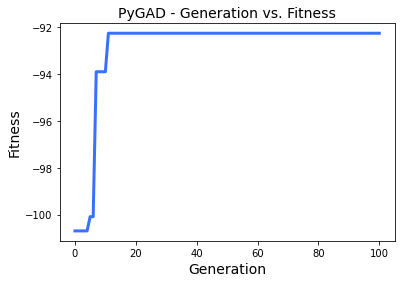

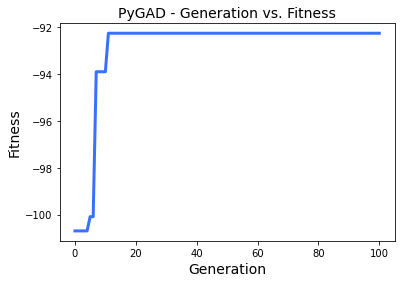

In [9]:
#uruchomienie algorytmu

czasy = []
fitnesy = []
min_fitness = 10000000000
max_fitness = -10000000000
for i in range(100):
    start = time.time()
    ga_instance = pygad.GA(gene_space=gene_space,
                       num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes,
                       allow_duplicate_genes=False)
    ga_instance.run()
    end = time.time()
    solution, solution_fitness, solution_idx = ga_instance.best_solution()
    czasy.append(end - start)
    fitnesy.append(solution_fitness)
    if min_fitness > solution_fitness:
        min_fitness = solution_fitness
    if max_fitness < solution_fitness:
        max_fitness = solution_fitness
print("Średni czas działania: ", np.mean(czasy))
print("Średnia wartość fitness: ", np.mean(fitnesy))
print("Minimalny fitness: ", min_fitness)
print("Maksymalny fitness: ", max_fitness)

klasa_problemu.append("mały")
ilosc_miast.append(miasta)
ilosc_aut.append(auta)
sredni_czas_dzialania.append(round(np.mean(czasy),2))
minimalny_fitness.append(round(min_fitness,2))
sredni_fitness.append(round(np.mean(fitnesy),2))
maksymalny_fitness.append(round(max_fitness,2))
dokladnosc.append(np.nan)
sposob_rozwiazania.append("AG bez PMX")

#ile generacji
print("Number of generations passed is {generations_completed}".format(generations_completed=ga_instance.generations_completed))

print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

#print("Predicted output based on the best solution : {prediction}".format(prediction=prediction))

#wyswietlenie wykresu: jak zmieniala sie ocena na przestrzeni pokolen
ga_instance.plot_fitness()

[0, 0]
[0, 3.0, 2.0, 1.0, 4.0, 0]


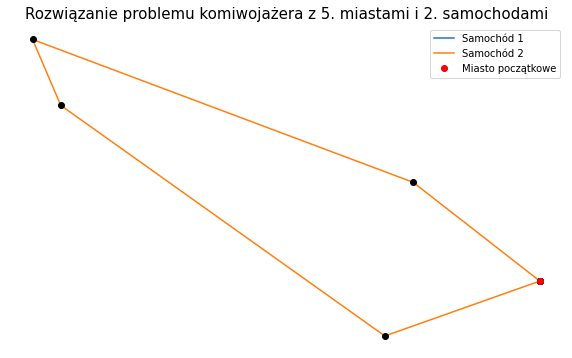

In [10]:
draw(Miasta, auta, solution) #bez PMX

Z PMX

Średni czas działania:  0.31807456254959104
Średnia wartość fitness:  -92.24699448762743
Minimalny fitness:  -92.24699448762746
Maksymalny fitness:  -92.24699448762745
Number of generations passed is 100
Parameters of the best solution : [6. 8. 7. 5. 3. 2. 1. 4.]
Fitness value of the best solution = -92.24699448762745


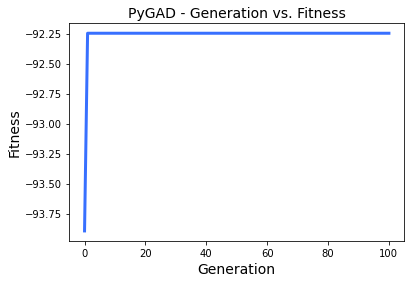

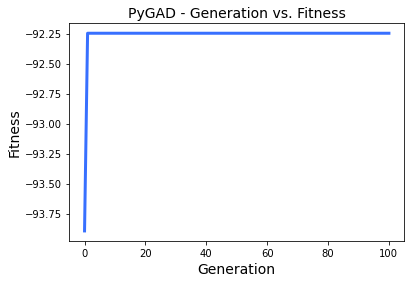

In [11]:
#uruchomienie algorytmu

czasy = []
fitnesy = []
min_fitness = 10000000000
max_fitness = -10000000000
for i in range(100):
    start = time.time()
    ga_instance = pygad.GA(gene_space=gene_space,
                       num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=PMX_crossover_func,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes,
                       allow_duplicate_genes=False)
    ga_instance.run()
    end = time.time()
    #podsumowanie: najlepsze znalezione rozwiazanie (chromosom+ocena)
    solution, solution_fitness, solution_idx = ga_instance.best_solution()
    czasy.append(end - start)
    fitnesy.append(solution_fitness)
    if min_fitness > solution_fitness:
        min_fitness = solution_fitness
    if max_fitness < solution_fitness:
        max_fitness = solution_fitness
print("Średni czas działania: ", np.mean(czasy))
print("Średnia wartość fitness: ", np.mean(fitnesy))
print("Minimalny fitness: ", min_fitness)
print("Maksymalny fitness: ", max_fitness)

klasa_problemu.append("mały")
ilosc_miast.append(miasta)
ilosc_aut.append(auta)
sredni_czas_dzialania.append(round(np.mean(czasy),2))
minimalny_fitness.append(round(min_fitness,2))
sredni_fitness.append(round(np.mean(fitnesy),2))
maksymalny_fitness.append(round(max_fitness,2))
dokladnosc.append(np.nan)
sposob_rozwiazania.append("AG z PMX")

#ile generacji
print("Number of generations passed is {generations_completed}".format(generations_completed=ga_instance.generations_completed))

print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

#print("Predicted output based on the best solution : {prediction}".format(prediction=prediction))

#wyswietlenie wykresu: jak zmieniala sie ocena na przestrzeni pokolen
ga_instance.plot_fitness()

[0, 0]
[0, 3.0, 2.0, 1.0, 4.0, 0]


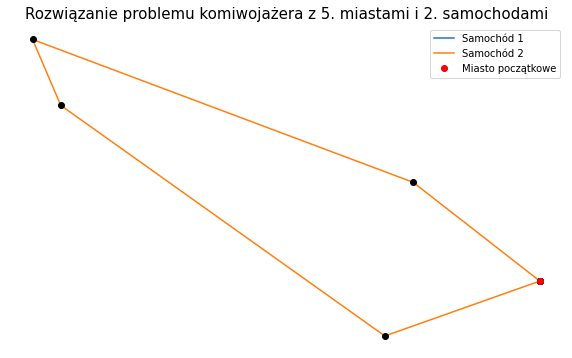

In [12]:
draw(Miasta, auta, solution)

Jak widać w powyższym przykładzie, w małych problemach nie ma znaczenia, które krzyżownie wybierzemy. Wartość funckji fitness również się niczym nie różni. Jest to jedyne sensowne rozwiązanie.

8 miast, 3 auta - z PMX

In [13]:
auta = 3
miasta = 8
Miasta = []
for i in range(miasta):
    Miasta.append([random.randint(0,100),random.randint(0,100)])
    
#wartosci w chromosomie
gene_space = range(1,(miasta - 1) * auta + 1)

num_genes = (miasta - 1) * auta 
#definiujemy dla każdego przykładu, bo dla każdego przykładu segmenty aut i miast się zmieniaja

Średni czas działania:  0.7870709347724915
Średnia wartość fitness:  -247.69877585405396
Minimalny fitness:  -247.82841991106207
Maksymalny fitness:  -244.94799217073574
Number of generations passed is 100
Parameters of the best solution : [13. 19.  9.  8. 18. 10. 21.  7. 12.  6. 15.  5.  3.  4.  1. 14. 17. 16.
  2. 11. 20.]
Fitness value of the best solution = -247.70613392899628


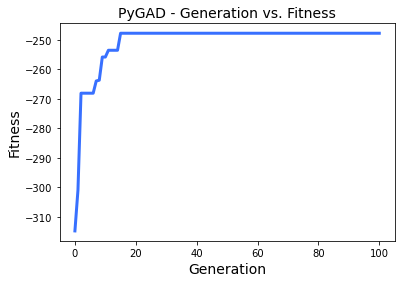

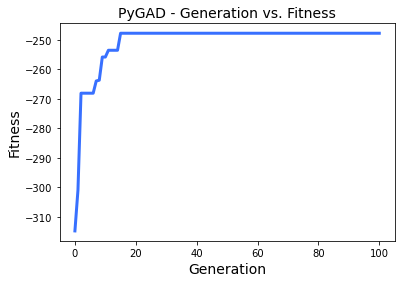

In [14]:
#uruchomienie algorytmu

czasy = []
fitnesy = []
min_fitness = 10000000000
max_fitness = -10000000000
for i in range(100):
    start = time.time()
    ga_instance = pygad.GA(gene_space=gene_space,
                       num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=PMX_crossover_func,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes,
                       allow_duplicate_genes=False)
    ga_instance.run()
    end = time.time()
    #podsumowanie: najlepsze znalezione rozwiazanie (chromosom+ocena)
    solution, solution_fitness, solution_idx = ga_instance.best_solution()
    czasy.append(end - start)
    fitnesy.append(solution_fitness)
    if min_fitness > solution_fitness:
        min_fitness = solution_fitness
    if max_fitness < solution_fitness:
        max_fitness = solution_fitness
print("Średni czas działania: ", np.mean(czasy))
print("Średnia wartość fitness: ", np.mean(fitnesy))
print("Minimalny fitness: ", min_fitness)
print("Maksymalny fitness: ", max_fitness)

klasa_problemu.append("mały")
ilosc_miast.append(miasta)
ilosc_aut.append(auta)
sredni_czas_dzialania.append(round(np.mean(czasy),2))
minimalny_fitness.append(round(min_fitness,2))
sredni_fitness.append(round(np.mean(fitnesy),2))
maksymalny_fitness.append(round(max_fitness,2))
dokladnosc.append(np.nan)
sposob_rozwiazania.append("AG z PMX")

#podsumowanie: najlepsze znalezione rozwiazanie (chromosom+ocena)
solution, solution_fitness, solution_idx = ga_instance.best_solution()

#ile generacji
print("Number of generations passed is {generations_completed}".format(generations_completed=ga_instance.generations_completed))

print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

#print("Predicted output based on the best solution : {prediction}".format(prediction=prediction))

#wyswietlenie wykresu: jak zmieniala sie ocena na przestrzeni pokolen
ga_instance.plot_fitness()

[0, 0]
[0, 7.0, 6.0, 5.0, 3.0, 4.0, 0]
[0, 1.0, 2.0, 0]


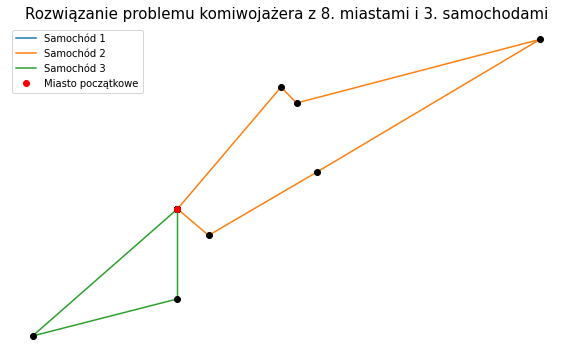

In [15]:
draw(Miasta, auta, solution)

Nasze best solution value jest najgorsze "z możliwych" (prawie równe minimum_fitness), ale graf wygląda na całkiem ok. Mogło być gorzej. Mamy w miarę wypukłe figury.

10 miast, 5 aut - z PMX

In [16]:
auta = 5
miasta = 10
Miasta = []
for i in range(miasta):
    Miasta.append([random.randint(0,100),random.randint(0,100)])
    
#wartosci w chromosomie
gene_space = range(1,(miasta - 1) * auta + 1)

num_genes = (miasta - 1) * auta

Średni czas działania:  2.4128917980194093
Średnia wartość fitness:  -365.7052240831511
Minimalny fitness:  -392.638311109771
Maksymalny fitness:  -326.6841976533424
Number of generations passed is 100
Parameters of the best solution : [44. 40. 24. 32. 17. 43. 11. 16. 37. 23. 34.  6.  1. 18.  5. 38.  4. 29.
  7. 35. 14. 15.  9.  2.  8.  3. 12. 27. 13. 36. 45. 21. 22. 10. 26. 19.
 20. 41. 25. 39. 28. 33. 42. 30. 31.]
Fitness value of the best solution = -379.1864037227601


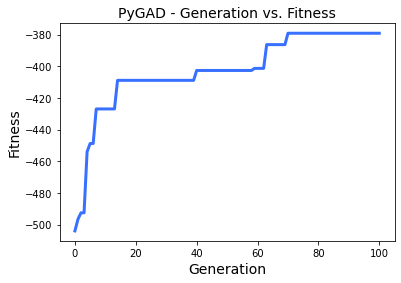

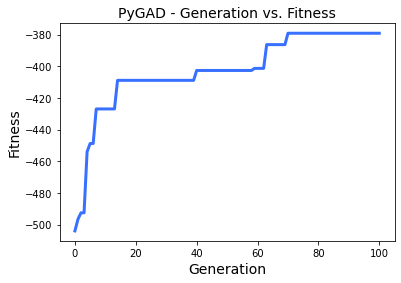

In [17]:
#uruchomienie algorytmu

czasy = []
fitnesy = []
min_fitness = 10000000000
max_fitness = -10000000000
for i in range(100):
    start = time.time()
    ga_instance = pygad.GA(gene_space=gene_space,
                       num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=PMX_crossover_func,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes,
                       allow_duplicate_genes=False)
    ga_instance.run()
    end = time.time()
    #podsumowanie: najlepsze znalezione rozwiazanie (chromosom+ocena)
    solution, solution_fitness, solution_idx = ga_instance.best_solution()
    czasy.append(end - start)
    fitnesy.append(solution_fitness)
    if min_fitness > solution_fitness:
        min_fitness = solution_fitness
    if max_fitness < solution_fitness:
        max_fitness = solution_fitness
print("Średni czas działania: ", np.mean(czasy))
print("Średnia wartość fitness: ", np.mean(fitnesy))
print("Minimalny fitness: ", min_fitness)
print("Maksymalny fitness: ", max_fitness)

klasa_problemu.append("mały")
ilosc_miast.append(miasta)
ilosc_aut.append(auta)
sredni_czas_dzialania.append(round(np.mean(czasy),2))
minimalny_fitness.append(round(min_fitness,2))
sredni_fitness.append(round(np.mean(fitnesy),2))
maksymalny_fitness.append(round(max_fitness,2))
dokladnosc.append(np.nan)
sposob_rozwiazania.append("AG z PMX")

#ile generacji
print("Number of generations passed is {generations_completed}".format(generations_completed=ga_instance.generations_completed))

print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

#print("Predicted output based on the best solution : {prediction}".format(prediction=prediction))

#wyswietlenie wykresu: jak zmieniala sie ocena na przestrzeni pokolen
ga_instance.plot_fitness()

[0, 0]
[0, 6.0, 1.0, 5.0, 4.0, 0]
[0, 7.0, 9.0, 2.0, 8.0, 3.0, 0]
[0, 0]
[0, 0]


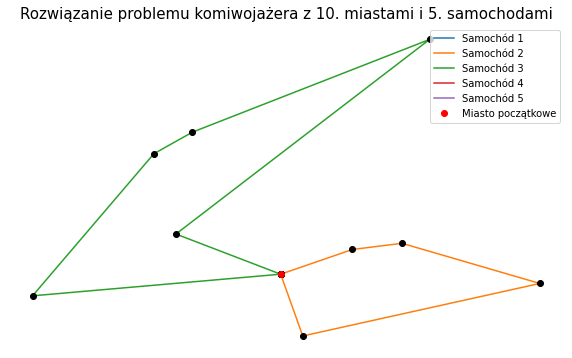

In [18]:
draw(Miasta, auta, solution)

Rozwiązanie gorsze od przeciętnego. Jak widać nie wykorzystał wszystkich samochodów. Bardziej optymalne byłoby rozwiązanie z 3 samochodów, wtedy byłaby szansa na powstanie figur wypukłych.

# II inputy średnie

Modyfikujemy parametry dla większych problemów

In [19]:
fitness_function = fitness_func

#ile chromsomów w populacji
#ile genow ma chromosom
sol_per_pop = 80 #im cięższy problem - zwiększamy
num_genes = (miasta-1) * auta #długość chromosomu - dla każdego auta segmenty miast

#ile wylaniamy rodzicow do "rozmanazania" (okolo 50% populacji)
#ile pokolen
#ilu rodzicow zachowac (kilka procent)
num_parents_mating = 40
num_generations = 850 #im cięższy problem - zwiększamy 
keep_parents = 2

#jaki typ selekcji rodzicow?
#sss = steady, rws=roulette, rank = rankingowa, tournament = turniejowa
parent_selection_type = "sss"

#w il =u punktach robic krzyzowanie?
crossover_type = "uniform"

#mutacja ma dzialac na ilu procent genow?
#trzeba pamietac ile genow ma chromosom
mutation_type = "random"
mutation_percent_genes = math.ceil(100/num_genes) #ma być jak najmniejsza możliwa

#inicjacja algorytmu z powyzszymi parametrami wpisanymi w atrybuty

15 miast, 3 auta - bez vs z PMX

In [20]:
auta = 3
miasta = 15
Miasta = []
for i in range(miasta):
    Miasta.append([random.randint(0,100),random.randint(0,100)])
    
#wartosci w chromosomie
gene_space = range(1,(miasta - 1) * auta + 1)

num_genes = (miasta - 1) * auta

bez PMX

Średni czas działania:  17.300124859809877
Średnia wartość fitness:  -441.49171365256495
Minimalny fitness:  -459.03617429430165
Maksymalny fitness:  -359.8470547153708
Number of generations passed is 850
Parameters of the best solution : [14.  5. 39. 10.  2.  9. 19.  1. 21. 28. 18. 38.  7. 22. 36. 34. 42. 40.
 20. 32. 24. 33. 26. 41. 23. 35. 16. 27.  3. 12. 11.  8.  6. 13.  4. 17.
 29. 25. 15. 30. 37. 31.]
Fitness value of the best solution = -451.4729476081228


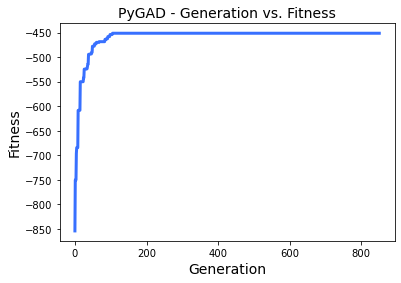

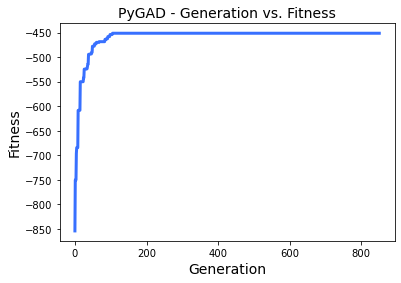

In [21]:
#uruchomienie algorytmu

czasy = []
fitnesy = []
min_fitness = 10000000000
max_fitness = -10000000000
for i in range(10):
    start = time.time()
    ga_instance = pygad.GA(gene_space=gene_space,
                       num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes,
                       allow_duplicate_genes=False)
    ga_instance.run()
    end = time.time()
    #podsumowanie: najlepsze znalezione rozwiazanie (chromosom+ocena)
    solution, solution_fitness, solution_idx = ga_instance.best_solution()
    czasy.append(end - start)
    fitnesy.append(solution_fitness)
    if min_fitness > solution_fitness:
        min_fitness = solution_fitness
    if max_fitness < solution_fitness:
        max_fitness = solution_fitness
print("Średni czas działania: ", np.mean(czasy))
print("Średnia wartość fitness: ", np.mean(fitnesy))
print("Minimalny fitness: ", min_fitness)
print("Maksymalny fitness: ", max_fitness)

klasa_problemu.append("średni")
ilosc_miast.append(miasta)
ilosc_aut.append(auta)
sredni_czas_dzialania.append(round(np.mean(czasy),2))
minimalny_fitness.append(round(min_fitness,2))
sredni_fitness.append(round(np.mean(fitnesy),2))
maksymalny_fitness.append(round(max_fitness,2))
dokladnosc.append(np.nan)
sposob_rozwiazania.append("AG bez PMX")

#ile generacji
print("Number of generations passed is {generations_completed}".format(generations_completed=ga_instance.generations_completed))

print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

#print("Predicted output based on the best solution : {prediction}".format(prediction=prediction))

#wyswietlenie wykresu: jak zmieniala sie ocena na przestrzeni pokolen
ga_instance.plot_fitness()

[0, 14.0, 5.0, 10.0, 2.0, 9.0, 1.0, 7.0, 0]
[0, 0]
[0, 3.0, 12.0, 11.0, 8.0, 6.0, 13.0, 4.0, 0]


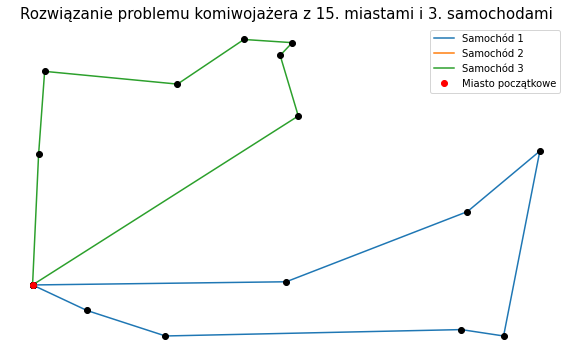

In [22]:
draw(Miasta, auta, solution)

Z PMX

Średni czas działania:  14.234397602081298
Średnia wartość fitness:  -468.5772186217444
Minimalny fitness:  -574.3727820981393
Maksymalny fitness:  -443.7555008288579
Number of generations passed is 850
Parameters of the best solution : [19. 39.  4. 13. 18. 41. 36.  6.  8. 23. 11. 12. 30.  3. 26. 37. 20. 29.
  7.  1. 17.  9.  2. 31. 10. 21.  5. 14. 34. 22. 15. 35. 25. 28. 42. 38.
 16. 32. 27. 40. 33. 24.]
Fitness value of the best solution = -451.47294760812275


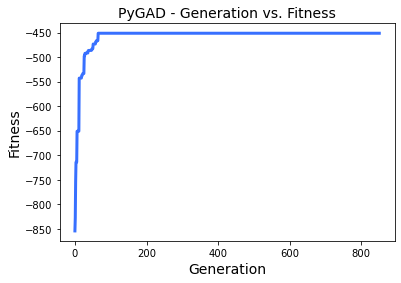

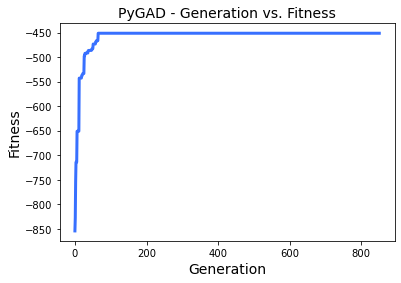

In [23]:
#uruchomienie algorytmu

czasy = []
fitnesy = []
min_fitness = 10000000000
max_fitness = -10000000000
for i in range(10):
    start = time.time()
    ga_instance = pygad.GA(gene_space=gene_space,
                       num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=PMX_crossover_func,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes,
                       allow_duplicate_genes=False)
    ga_instance.run()
    end = time.time()
    #podsumowanie: najlepsze znalezione rozwiazanie (chromosom+ocena)
    solution, solution_fitness, solution_idx = ga_instance.best_solution()
    czasy.append(end - start)
    fitnesy.append(solution_fitness)
    if min_fitness > solution_fitness:
        min_fitness = solution_fitness
    if max_fitness < solution_fitness:
        max_fitness = solution_fitness
print("Średni czas działania: ", np.mean(czasy))
print("Średnia wartość fitness: ", np.mean(fitnesy))
print("Minimalny fitness: ", min_fitness)
print("Maksymalny fitness: ", max_fitness)

klasa_problemu.append("średni")
ilosc_miast.append(miasta)
ilosc_aut.append(auta)
sredni_czas_dzialania.append(round(np.mean(czasy),2))
minimalny_fitness.append(round(min_fitness,2))
sredni_fitness.append(round(np.mean(fitnesy),2))
maksymalny_fitness.append(round(max_fitness,2))
dokladnosc.append(np.nan)
sposob_rozwiazania.append("AG z PMX")

#ile generacji
print("Number of generations passed is {generations_completed}".format(generations_completed=ga_instance.generations_completed))

print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

#print("Predicted output based on the best solution : {prediction}".format(prediction=prediction))

#wyswietlenie wykresu: jak zmieniala sie ocena na przestrzeni pokolen
ga_instance.plot_fitness()

[0, 4.0, 13.0, 6.0, 8.0, 11.0, 12.0, 3.0, 0]
[0, 7.0, 1.0, 9.0, 2.0, 10.0, 5.0, 14.0, 0]
[0, 0]


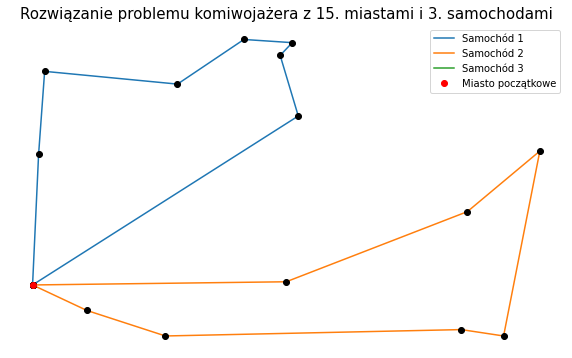

In [24]:
draw(Miasta, auta, solution)

Rozwiązania niczym się nie różnią. Są całkiem dobre i optymalne.

12 miast, 4 auta - z PMX

In [25]:
auta = 4
miasta = 12
Miasta = []
for i in range(miasta):
    Miasta.append([random.randint(0,100),random.randint(0,100)])
    
#wartosci w chromosomie
gene_space = range(1,(miasta - 1) * auta + 1)

num_genes = (miasta - 1) * auta

Średni czas działania:  15.038045167922974
Średnia wartość fitness:  -345.81879976709445
Minimalny fitness:  -361.8372651853659
Maksymalny fitness:  -322.5036367815165
Number of generations passed is 850
Parameters of the best solution : [22. 11.  5.  3. 29. 40.  1.  7.  6.  9.  4. 36. 14. 25. 37. 28. 24. 27.
 43. 33. 39. 34. 17. 26. 31. 18. 23. 21. 16. 35. 19. 44. 30. 41. 13.  2.
 12. 42.  8. 10. 20. 38. 15. 32.]
Fitness value of the best solution = -322.5036367815165


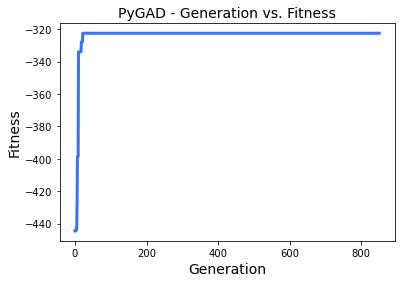

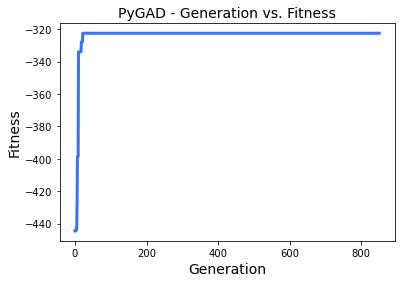

In [26]:
#uruchomienie algorytmu

czasy = []
fitnesy = []
min_fitness = 10000000000
max_fitness = -10000000000
for i in range(10):
    start = time.time()
    ga_instance = pygad.GA(gene_space=gene_space,
                       num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=PMX_crossover_func,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes,
                       allow_duplicate_genes=False)
    ga_instance.run()
    end = time.time()
    #podsumowanie: najlepsze znalezione rozwiazanie (chromosom+ocena)
    solution, solution_fitness, solution_idx = ga_instance.best_solution()
    czasy.append(end - start)
    fitnesy.append(solution_fitness)
    if min_fitness > solution_fitness:
        min_fitness = solution_fitness
    if max_fitness < solution_fitness:
        max_fitness = solution_fitness
print("Średni czas działania: ", np.mean(czasy))
print("Średnia wartość fitness: ", np.mean(fitnesy))
print("Minimalny fitness: ", min_fitness)
print("Maksymalny fitness: ", max_fitness)

klasa_problemu.append("średni")
ilosc_miast.append(miasta)
ilosc_aut.append(auta)
sredni_czas_dzialania.append(round(np.mean(czasy),2))
minimalny_fitness.append(round(min_fitness,2))
sredni_fitness.append(round(np.mean(fitnesy),2))
maksymalny_fitness.append(round(max_fitness,2))
dokladnosc.append(np.nan)
sposob_rozwiazania.append("AG z PMX")

#ile generacji
print("Number of generations passed is {generations_completed}".format(generations_completed=ga_instance.generations_completed))

print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

#print("Predicted output based on the best solution : {prediction}".format(prediction=prediction))

#wyswietlenie wykresu: jak zmieniala sie ocena na przestrzeni pokolen
ga_instance.plot_fitness()

[0, 11.0, 5.0, 3.0, 1.0, 7.0, 6.0, 9.0, 4.0, 0]
[0, 0]
[0, 0]
[0, 2.0, 8.0, 10.0, 0]


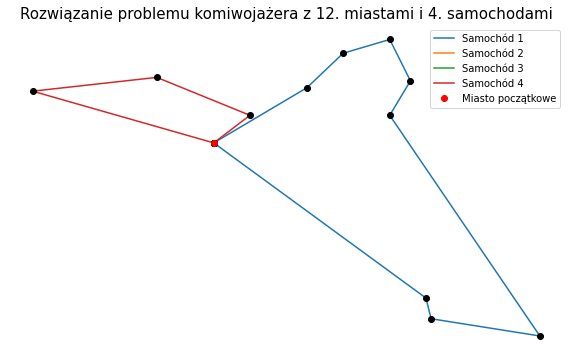

In [27]:
draw(Miasta, auta, solution)

Fitness value jest najlepsze znalezione. Widać, że jest to optymalne rozwiązanie ponieważ każdy z samochodów ma swoją "stronę", nie nachodzą się - czyli nie generują dodatkowych kosztów. 

15 miast, 6 aut - z PMX

In [28]:
auta = 6
miasta = 15
Miasta = []
for i in range(miasta):
    Miasta.append([random.randint(0,100),random.randint(0,100)])
    
#wartosci w chromosomie
gene_space = range(1,(miasta - 1) * auta + 1)

num_genes = (miasta - 1) * auta

Średni czas działania:  43.89826004505157
Średnia wartość fitness:  -443.6091344231759
Minimalny fitness:  -476.8919093065598
Maksymalny fitness:  -394.4282883980208
Number of generations passed is 850
Parameters of the best solution : [14. 31.  2.  6.  7. 45. 11. 12. 55.  8. 53. 10.  3.  1. 22. 67. 82. 17.
 65. 36. 38. 51. 71. 29. 50. 75. 66. 19. 61. 41. 60. 46. 69. 76. 81. 25.
 56. 62. 20. 77. 26. 59. 70. 30. 33. 83. 44. 42. 84. 48. 27. 28. 68. 34.
 15. 78. 74. 18. 52. 37. 39. 47. 21. 63. 72. 73. 64. 40. 35. 32.  4.  9.
  5. 79. 49. 23. 58. 80. 16. 13. 43. 54. 57. 24.]
Fitness value of the best solution = -401.76700035043683


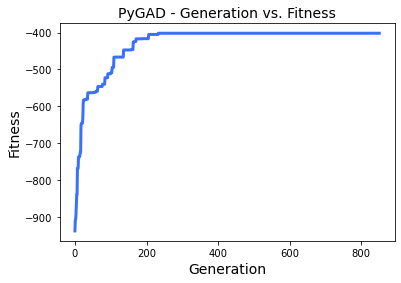

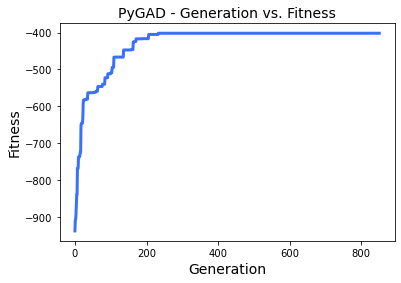

In [29]:
#uruchomienie algorytmu

czasy = []
fitnesy = []
min_fitness = 10000000000
max_fitness = -10000000000
for i in range(10):
    start = time.time()
    ga_instance = pygad.GA(gene_space=gene_space,
                       num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=PMX_crossover_func,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes,
                       allow_duplicate_genes=False)
    ga_instance.run()
    end = time.time()
    #podsumowanie: najlepsze znalezione rozwiazanie (chromosom+ocena)
    solution, solution_fitness, solution_idx = ga_instance.best_solution()
    czasy.append(end - start)
    fitnesy.append(solution_fitness)
    if min_fitness > solution_fitness:
        min_fitness = solution_fitness
    if max_fitness < solution_fitness:
        max_fitness = solution_fitness
print("Średni czas działania: ", np.mean(czasy))
print("Średnia wartość fitness: ", np.mean(fitnesy))
print("Minimalny fitness: ", min_fitness)
print("Maksymalny fitness: ", max_fitness)

klasa_problemu.append("średni")
ilosc_miast.append(miasta)
ilosc_aut.append(auta)
sredni_czas_dzialania.append(round(np.mean(czasy),2))
minimalny_fitness.append(round(min_fitness,2))
sredni_fitness.append(round(np.mean(fitnesy),2))
maksymalny_fitness.append(round(max_fitness,2))
dokladnosc.append(np.nan)
sposob_rozwiazania.append("AG z PMX")

#ile generacji
print("Number of generations passed is {generations_completed}".format(generations_completed=ga_instance.generations_completed))

print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

#print("Predicted output based on the best solution : {prediction}".format(prediction=prediction))

#wyswietlenie wykresu: jak zmieniala sie ocena na przestrzeni pokolen
ga_instance.plot_fitness()

[0, 14.0, 2.0, 6.0, 7.0, 11.0, 12.0, 8.0, 10.0, 3.0, 1.0, 0]
[0, 0]
[0, 0]
[0, 0]
[0, 0]
[0, 4.0, 9.0, 5.0, 13.0, 0]


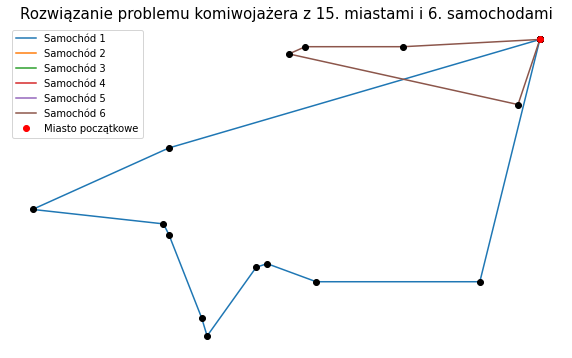

In [30]:
draw(Miasta, auta, solution)

Rozwiązanie z jednej strony dobre po względem funckcji fitness, a na grafie dosyć średnie. Myślę, że jakby w gre weszły 3 samochody i każdy pojechał w inną stronę świata to byłoby to optymalniejsze.

# III inputy duże

Modyfikujemy parametry

In [31]:
fitness_function = fitness_func

#ile chromsomów w populacji
#ile genow ma chromosom
sol_per_pop = 100 #im cięższy problem - zwiększamy
num_genes = (miasta-1) * auta #długość chromosomu - dla każdego auta segmenty miast

#ile wylaniamy rodzicow do "rozmanazania" (okolo 50% populacji)
#ile pokolen
#ilu rodzicow zachowac (kilka procent)
num_parents_mating = 50
num_generations = 1000 #im cięższy problem - zwiększamy 
keep_parents = 2

#jaki typ selekcji rodzicow?
#sss = steady, rws=roulette, rank = rankingowa, tournament = turniejowa
parent_selection_type = "sss"

#w il =u punktach robic krzyzowanie?
crossover_type = "uniform"

#mutacja ma dzialac na ilu procent genow?
#trzeba pamietac ile genow ma chromosom
mutation_type = "random"
mutation_percent_genes = math.ceil(100/num_genes) #ma być jak najmniejsza możliwa

#inicjacja algorytmu z powyzszymi parametrami wpisanymi w atrybuty

25 miast, 5 aut - bez vs z PMX

In [32]:
auta = 5
miasta = 25
Miasta = []
for i in range(miasta):
    Miasta.append([random.randint(0, 100),random.randint(0, 100)])
    
#wartosci w chromosomie
gene_space = range(1,(miasta - 1) * auta + 1)

num_genes = (miasta - 1) * auta

Bez PMX

Średni czas działania:  101.53831171989441
Średnia wartość fitness:  -611.631258190014
Minimalny fitness:  -806.4856629294903
Maksymalny fitness:  -548.6963709184495
Number of generations passed is 1000
Parameters of the best solution : [  7.   9.  53.  84.  14.  11. 108.  89.  15.  12.   1.  34.  18.  20.
  13.  24.   3.  81.   2.  35.  82.   4.   5.  16.  91.  85.  95.  37.
  42.  32.  31.  67.  59. 102.  39.  50. 118.  80. 110.  71.  55.  36.
  27.  38. 104.  66. 117.  28.  56.  43.  68. 114. 103.  61.  33.  72.
  51.  88.  25.  78.  63.  77.  70.  58.  49.  75.  86.  79.  60. 107.
  94.  69.  73.  74. 105.  57. 120. 116. 106.  62. 101.  41.  48.  99.
  93.  87.  98.  64.  92.  40.  46.  54. 112. 100.  97. 119.  19.   6.
  22.  21.  17.  65.   8.  30.  47. 115.  90.  10.  52.  23.  44.  83.
  26. 109. 111.  29.  45. 113.  96.  76.]
Fitness value of the best solution = -567.4086252184815


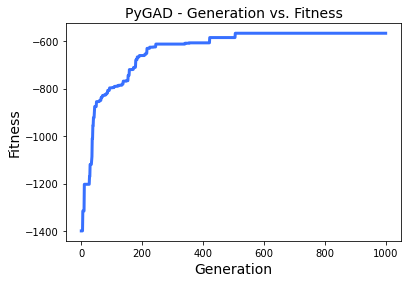

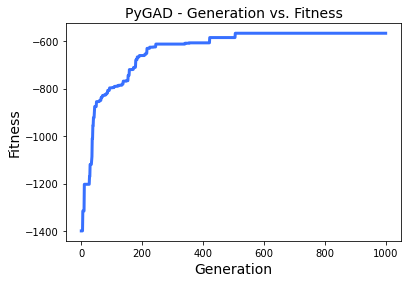

In [33]:
#uruchomienie algorytmu

czasy = []
fitnesy = []
min_fitness = 10000000000
max_fitness = -10000000000
for i in range(10):
    start = time.time()
    ga_instance = pygad.GA(gene_space=gene_space,
                       num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes,
                       allow_duplicate_genes=False)
    ga_instance.run()
    end = time.time()
    #podsumowanie: najlepsze znalezione rozwiazanie (chromosom+ocena)
    solution, solution_fitness, solution_idx = ga_instance.best_solution()
    czasy.append(end - start)
    fitnesy.append(solution_fitness)
    if min_fitness > solution_fitness:
        min_fitness = solution_fitness
    if max_fitness < solution_fitness:
        max_fitness = solution_fitness
print("Średni czas działania: ", np.mean(czasy))
print("Średnia wartość fitness: ", np.mean(fitnesy))
print("Minimalny fitness: ", min_fitness)
print("Maksymalny fitness: ", max_fitness)

klasa_problemu.append("duży")
ilosc_miast.append(miasta)
ilosc_aut.append(auta)
sredni_czas_dzialania.append(round(np.mean(czasy),2))
minimalny_fitness.append(round(min_fitness,2))
sredni_fitness.append(round(np.mean(fitnesy),2))
maksymalny_fitness.append(round(max_fitness,2))
dokladnosc.append(np.nan)
sposob_rozwiazania.append("AG bez PMX")

#ile generacji
print("Number of generations passed is {generations_completed}".format(generations_completed=ga_instance.generations_completed))

print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

#print("Predicted output based on the best solution : {prediction}".format(prediction=prediction))

#wyswietlenie wykresu: jak zmieniala sie ocena na przestrzeni pokolen
ga_instance.plot_fitness()

[0, 7.0, 9.0, 14.0, 11.0, 15.0, 12.0, 1.0, 18.0, 20.0, 13.0, 24.0, 3.0, 2.0, 4.0, 5.0, 16.0, 0]
[0, 0]
[0, 0]
[0, 0]
[0, 19.0, 6.0, 22.0, 21.0, 17.0, 8.0, 10.0, 23.0, 0]


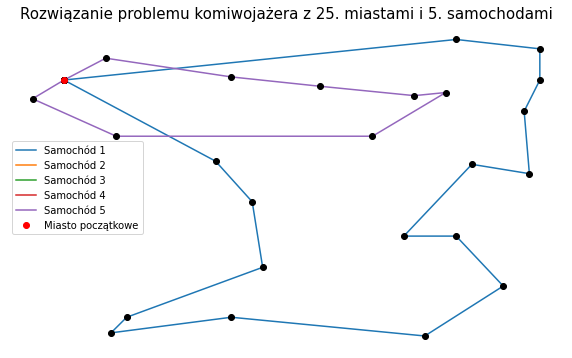

In [34]:
draw(Miasta, auta, solution)

Z PMX

Średni czas działania:  109.8381089925766
Średnia wartość fitness:  -636.228707339256
Minimalny fitness:  -737.912438836464
Maksymalny fitness:  -557.732842665135
Number of generations passed is 1000
Parameters of the best solution : [ 23.   2. 113.  95.   3. 102.  40.  99. 115.  24.  43.   4.  55.   1.
  31.  18.  20. 105.  13.  83.   5.  16. 103.  10.   8.  78.  81. 100.
  50.  69.  41.  94.  12.  80.  15.  11.  14.   9.   7.  17.  54.  44.
  21.  74.  53.  22.   6.  19. 114. 117.  89.  76.  59. 107. 119.  91.
  42.  46.  30.  37.  51.  48. 116.  88.  60. 112.  49.  61.  26.  72.
  71. 110.  29.  47.  38.  27.  32.  67.  84. 104.  62.  65.  97.  63.
  64.  57.  25. 120. 101.  33.  45.  96.  75.  98.  87.  70.  58.  93.
  79.  86.  90.  28.  66.  77.  56.  92.  73. 108.  36. 111. 118.  52.
  34. 106.  39.  35.  85.  82. 109.  68.]
Fitness value of the best solution = -561.4093466028435


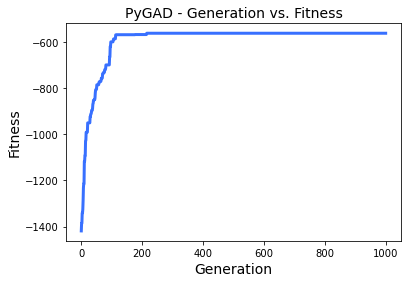

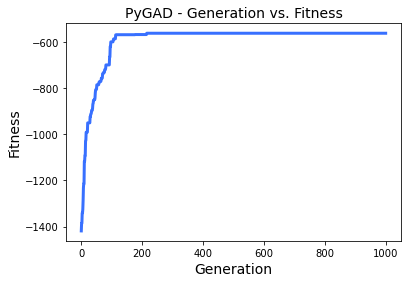

In [35]:
#uruchomienie algorytmu

czasy = []
fitnesy = []
min_fitness = 10000000000
max_fitness = -10000000000
for i in range(10):
    start = time.time()
    ga_instance = pygad.GA(gene_space=gene_space,
                       num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=PMX_crossover_func,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes,
                       allow_duplicate_genes=False)
    ga_instance.run()
    end = time.time()
    czasy.append(end - start)
    #podsumowanie: najlepsze znalezione rozwiazanie (chromosom+ocena)
    solution, solution_fitness, solution_idx = ga_instance.best_solution()
    fitnesy.append(solution_fitness)
    if min_fitness > solution_fitness:
        min_fitness = solution_fitness
    if max_fitness < solution_fitness:
        max_fitness = solution_fitness
print("Średni czas działania: ", np.mean(czasy))
print("Średnia wartość fitness: ", np.mean(fitnesy))
print("Minimalny fitness: ", min_fitness)
print("Maksymalny fitness: ", max_fitness)

klasa_problemu.append("duży")
ilosc_miast.append(miasta)
ilosc_aut.append(auta)
sredni_czas_dzialania.append(round(np.mean(czasy),2))
minimalny_fitness.append(round(min_fitness,2))
sredni_fitness.append(round(np.mean(fitnesy),2))
maksymalny_fitness.append(round(max_fitness,2))
dokladnosc.append(np.nan)
sposob_rozwiazania.append("AG z PMX")

#ile generacji
print("Number of generations passed is {generations_completed}".format(generations_completed=ga_instance.generations_completed))

print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

#print("Predicted output based on the best solution : {prediction}".format(prediction=prediction))

#wyswietlenie wykresu: jak zmieniala sie ocena na przestrzeni pokolen
ga_instance.plot_fitness()

[0, 23.0, 2.0, 3.0, 24.0, 4.0, 1.0, 18.0, 20.0, 13.0, 5.0, 16.0, 10.0, 0]
[0, 8.0, 12.0, 15.0, 11.0, 14.0, 9.0, 7.0, 17.0, 21.0, 22.0, 6.0, 19.0, 0]
[0, 0]
[0, 0]
[0, 0]


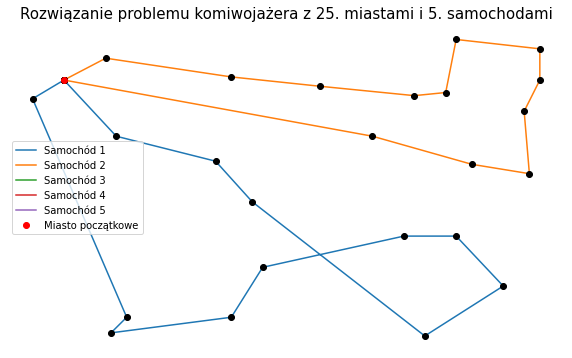

In [36]:
draw(Miasta, auta, solution)

Rozwiązanie z PMX ewidentnie prezentuje się bardziej optymalnie. Co jest dosyć dziwne przy tak bliskich wartościach fitness. W pierwszym rozwiązaniu krzyżowanie tras dla mnie nie wchodzi w grę. W drugim jedyne co mi mało odpowiada to ta "pętelka", domniemywam że maksymalny fitness - najlepsze rozwiązanie jest właśnie bez niej.

30 miast, 5 aut - z PMX

In [37]:
auta = 5
miasta = 30
Miasta = []
for i in range(miasta):
    Miasta.append([random.randint(0, 100),random.randint(0, 100)])
    
#wartosci w chromosomie
gene_space = range(1,(miasta - 1) * auta + 1)

num_genes = (miasta - 1) * auta

Średni czas działania:  147.32796149253846
Średnia wartość fitness:  -637.4754481846036
Minimalny fitness:  -712.129530532912
Maksymalny fitness:  -589.4604607412899
Number of generations passed is 1000
Parameters of the best solution : [ 56.  70. 108.  91.  45. 101.  54. 110. 100. 107. 114.  50.   9.  40.
 145.  58.  61. 131. 102.  51.  79.  55.  99. 113.  38.   3.  67.  43.
  25.  35.  82.  97.  74.  17.  71.  41. 139.  60.  68.  48. 121.  28.
  78. 106.  42.  75. 123.  89.  80. 132.  26. 133. 127.   8.  15. 128.
 105.  13.  19.  12. 120.  92.  10.   1.  98.  84. 130. 104.  90.   6.
  18.  32.  76. 122. 119. 134.  49.  20.  85.  46.  66.  63.  11. 126.
 140.  22.  69.  88.  31. 115.  27.  16.  24. 135. 118.  30.  39. 143.
 129.  23.  59.  29. 136.   7.  37.   5.  95.   4.  93. 111.  33.  14.
  52.  21.   2. 124.  62.  96.  81.  87.  94. 137.  83.  86. 125.  36.
 116. 138.  47. 142. 103.  64.  57.  72. 112. 144.  73.  65.  44.  34.
 109.  53. 141. 117.  77.]
Fitness value of the best 

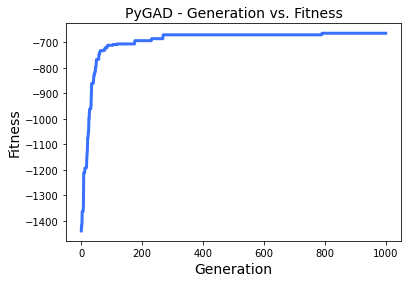

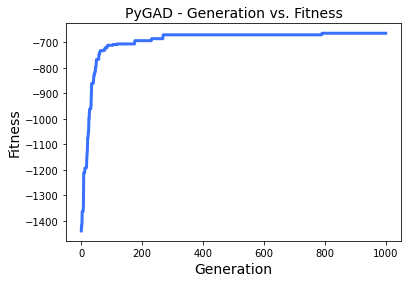

In [38]:
#uruchomienie algorytmu

czasy = []
fitnesy = []
min_fitness = 10000000000
max_fitness = -10000000000
for i in range(10):
    start = time.time()
    ga_instance = pygad.GA(gene_space=gene_space,
                       num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=PMX_crossover_func,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes,
                       allow_duplicate_genes=False)
    ga_instance.run()
    end = time.time()
    #podsumowanie: najlepsze znalezione rozwiazanie (chromosom+ocena)
    solution, solution_fitness, solution_idx = ga_instance.best_solution()
    czasy.append(end - start)
    fitnesy.append(solution_fitness)
    if min_fitness > solution_fitness:
        min_fitness = solution_fitness
    if max_fitness < solution_fitness:
        max_fitness = solution_fitness
print("Średni czas działania: ", np.mean(czasy))
print("Średnia wartość fitness: ", np.mean(fitnesy))
print("Minimalny fitness: ", min_fitness)
print("Maksymalny fitness: ", max_fitness)

klasa_problemu.append("duży")
ilosc_miast.append(miasta)
ilosc_aut.append(auta)
sredni_czas_dzialania.append(round(np.mean(czasy),2))
minimalny_fitness.append(round(min_fitness,2))
sredni_fitness.append(round(np.mean(fitnesy),2))
maksymalny_fitness.append(round(max_fitness,2))
dokladnosc.append(np.nan)
sposob_rozwiazania.append("AG z PMX")

#ile generacji
print("Number of generations passed is {generations_completed}".format(generations_completed=ga_instance.generations_completed))

print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

#print("Predicted output based on the best solution : {prediction}".format(prediction=prediction))

#wyswietlenie wykresu: jak zmieniala sie ocena na przestrzeni pokolen
ga_instance.plot_fitness()

[0, 9.0, 3.0, 25.0, 0]
[0, 17.0, 28.0, 26.0, 8.0, 15.0, 13.0, 0]
[0, 19.0, 12.0, 10.0, 1.0, 6.0, 18.0, 20.0, 11.0, 22.0, 0]
[0, 27.0, 16.0, 24.0, 23.0, 29.0, 7.0, 5.0, 4.0, 14.0, 21.0, 2.0, 0]
[0, 0]


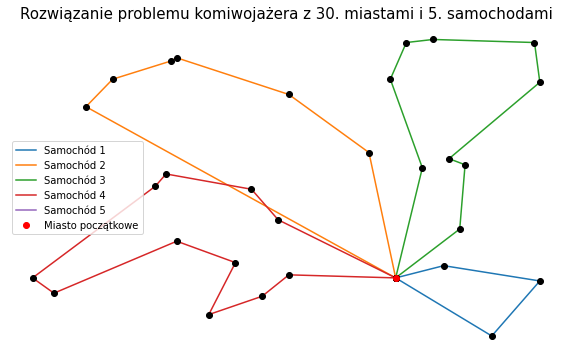

In [39]:
draw(Miasta, auta, solution)

Problem dość ciężki, fitness value przeciętne. Graf prócz małego krzyżowania niczego sobie. Jestem zadowolona z wyniku. Widać, że program "wie o co chodzi" i stara się dobrać jak najlepsze rozwiązanie.

50 miast, 4 auta - z PMX

In [40]:
auta = 4
miasta = 50
Miasta = []
for i in range(miasta):
    Miasta.append([random.randint(0, 100),random.randint(0, 100)])
    
#wartosci w chromosomie
gene_space = range(1,(miasta - 1) * auta + 1)

num_genes = (miasta - 1) * auta

Średni czas działania:  263.39809534549715
Średnia wartość fitness:  -930.0416917356328
Minimalny fitness:  -1022.4375162256811
Maksymalny fitness:  -832.6487644861478
Number of generations passed is 1000
Parameters of the best solution : [118.  13. 126.  49. 104.  54.  68.  83. 140. 189. 170. 102. 133. 143.
  10.  42.  66.  41. 194. 135.   4. 164.  62. 129. 188.  17.  64. 136.
 153. 110.  35.  22. 111. 192.  15. 161.  96. 115.  45.  78.  37. 173.
  69.  72.  44.  82. 112.  48. 181.  60. 179. 120.  87.  93.  85.  55.
  71.  75.   5.  67. 182.  25. 171. 108.  57. 100.  80. 131.  63.  70.
  31.  32. 163.  28.  30.  36.  81. 144. 157.  76.   2. 158. 121. 186.
 146.  23.  16.  18. 178.  86. 149. 101.  84. 134. 168. 147. 150.  89.
  59. 139. 180.  88. 128.  56. 175. 137.  79. 151.  91. 184. 148.  33.
  34.   8. 117. 193.   1.   9.  53. 132. 116. 105. 114. 124. 177. 154.
 162. 169. 176. 187.  46. 160.  61.   7.  26.  52.  99.  39. 166.  98.
 195. 165.  58. 138.  27.  43. 183.  21.   3.  29. 

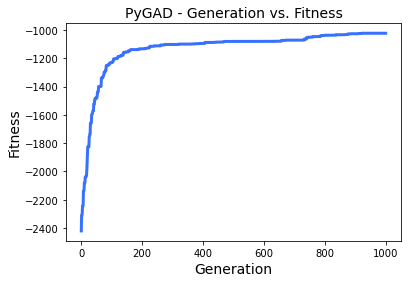

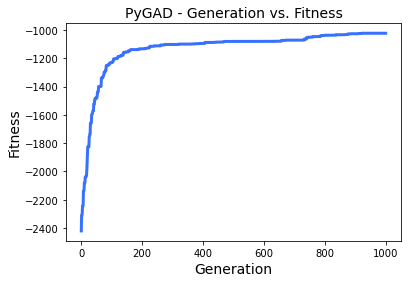

In [41]:
#uruchomienie algorytmu

czasy = []
fitnesy = []
min_fitness = 10000000000
max_fitness = -10000000000
for i in range(10):
    start = time.time()
    ga_instance = pygad.GA(gene_space=gene_space,
                       num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=PMX_crossover_func,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes,
                       allow_duplicate_genes=False)
    ga_instance.run()
    end = time.time()
    #podsumowanie: najlepsze znalezione rozwiazanie (chromosom+ocena)
    solution, solution_fitness, solution_idx = ga_instance.best_solution()
    czasy.append(end - start)
    fitnesy.append(solution_fitness)
    if min_fitness > solution_fitness:
        min_fitness = solution_fitness
    if max_fitness < solution_fitness:
        max_fitness = solution_fitness
print("Średni czas działania: ", np.mean(czasy))
print("Średnia wartość fitness: ", np.mean(fitnesy))
print("Minimalny fitness: ", min_fitness)
print("Maksymalny fitness: ", max_fitness)

klasa_problemu.append("duży")
ilosc_miast.append(miasta)
ilosc_aut.append(auta)
sredni_czas_dzialania.append(round(np.mean(czasy),2))
minimalny_fitness.append(round(min_fitness,2))
sredni_fitness.append(round(np.mean(fitnesy),2))
maksymalny_fitness.append(round(max_fitness,2))
dokladnosc.append(np.nan)
sposob_rozwiazania.append("AG z PMX")

#ile generacji
print("Number of generations passed is {generations_completed}".format(generations_completed=ga_instance.generations_completed))

print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

#print("Predicted output based on the best solution : {prediction}".format(prediction=prediction))

#wyswietlenie wykresu: jak zmieniala sie ocena na przestrzeni pokolen
ga_instance.plot_fitness()

[0, 13.0, 49.0, 10.0, 42.0, 41.0, 4.0, 17.0, 35.0, 22.0, 15.0, 45.0, 37.0, 44.0, 48.0, 0]
[0, 5.0, 25.0, 31.0, 32.0, 28.0, 30.0, 36.0, 2.0, 23.0, 16.0, 18.0, 0]
[0, 33.0, 34.0, 8.0, 1.0, 9.0, 46.0, 7.0, 26.0, 39.0, 27.0, 43.0, 0]
[0, 21.0, 3.0, 29.0, 12.0, 38.0, 14.0, 40.0, 20.0, 6.0, 11.0, 19.0, 24.0, 47.0, 0]


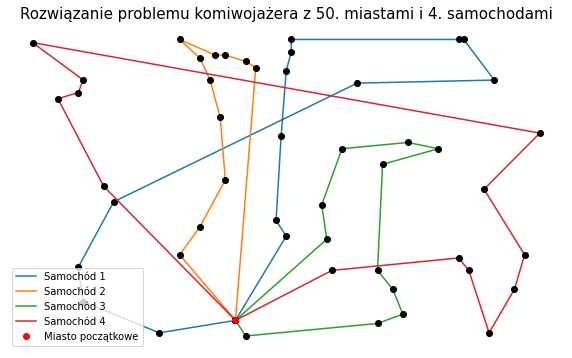

In [42]:
draw(Miasta, auta, solution)

Problem dość ciężki nie tylko ze względu na ilość miast i dostępnych samochodów, ale również położenie startowego miasta nie jest korzystne. Akurat los tak chciał, że program wyrzucił nam najgorsze rozwiązanie i widać że jest fatalne. Daje nam to jednak nadzieje, że jak tak juz kombinuje w najgorszym to najlepsze będzie jak najbardziej na medal.

Zmieńmy parametry dla dużych problemów i zobaczmy co się stanie

In [43]:
fitness_function = fitness_func

#ile chromsomów w populacji
#ile genow ma chromosom
sol_per_pop = 150 #im cięższy problem - zwiększamy
num_genes = (miasta-1) * auta #długość chromosomu - dla każdego auta segmenty miast

#ile wylaniamy rodzicow do "rozmanazania" (okolo 50% populacji)
#ile pokolen
#ilu rodzicow zachowac (kilka procent)
num_parents_mating = 75
num_generations = 1500 #im cięższy problem - zwiększamy 
keep_parents = 2

#jaki typ selekcji rodzicow?
#sss = steady, rws=roulette, rank = rankingowa, tournament = turniejowa
parent_selection_type = "sss"

#w il =u punktach robic krzyzowanie?
crossover_type = "uniform"

#mutacja ma dzialac na ilu procent genow?
#trzeba pamietac ile genow ma chromosom
mutation_type = "random"
mutation_percent_genes = math.ceil(100/num_genes) #ma być jak najmniejsza możliwa

#inicjacja algorytmu z powyzszymi parametrami wpisanymi w atrybuty

In [44]:
auta = 4
miasta = 50
Miasta = []
for i in range(miasta):
    Miasta.append([random.randint(0, 100),random.randint(0, 100)])
    
#wartosci w chromosomie
gene_space = range(1,(miasta - 1) * auta + 1)

num_genes = (miasta - 1) * auta

Number of generations passed is 1500
Parameters of the best solution : [139. 157. 146. 132. 125.  87. 124. 186.  74. 101. 184.  61.  95. 121.
 122.  75. 159. 145.  12.  99.  82.  72. 164. 178. 193. 102. 133.   1.
 177.  27. 147. 180. 143.  41.  45. 149. 115.  43. 151. 168. 155. 161.
 141.   2. 163.  70. 181.  86.  22. 116. 172. 113. 129.  90. 176.  59.
 106.  88. 108.  98. 135. 196.  60. 158. 171. 166.  66.  56. 169.  32.
 119.  10. 130. 190.  53. 152. 131. 160. 127. 165. 173. 185. 153. 114.
  77.  18. 187.  58. 134. 126. 188.  68. 191.  69. 194.   5.  36.  19.
 174. 123.  83. 104.  11.  30.  25.  33. 167.  93.   8.  64. 182.  62.
  78.  71.  63.  97. 117.  91. 138. 170.  15.  55.  17.  50.  73. 120.
 100. 183.  89.  81. 148.  76.  79.  44.  23. 118.  38.  48.  57.  80.
   3.  51.   9.  46.  92.  52.  42. 142.  24.  26. 179.  35.   6.  39.
  34.  40.  21.  37. 137. 162.  65. 150.  20.  96.  94. 128. 140. 112.
  84.  47.  54.  13. 111. 109. 103. 154. 195.   4. 175.  31.  14. 105.
 189. 

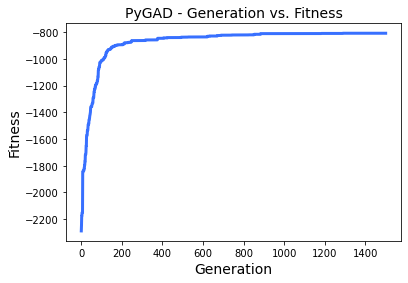

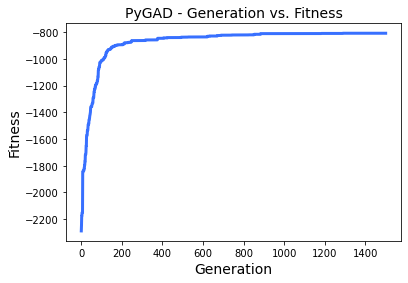

In [45]:
#uruchomienie algorytmu
ga_instance = pygad.GA(gene_space=gene_space,
                       num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=PMX_crossover_func,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes,
                       allow_duplicate_genes=False)

ga_instance.run()

#podsumowanie: najlepsze znalezione rozwiazanie (chromosom+ocena)
solution, solution_fitness, solution_idx = ga_instance.best_solution()

#ile generacji
print("Number of generations passed is {generations_completed}".format(generations_completed=ga_instance.generations_completed))

print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

#print("Predicted output based on the best solution : {prediction}".format(prediction=prediction))

#wyswietlenie wykresu: jak zmieniala sie ocena na przestrzeni pokolen
ga_instance.plot_fitness()

[0, 12.0, 1.0, 27.0, 41.0, 45.0, 43.0, 2.0, 22.0, 0]
[0, 32.0, 10.0, 18.0, 5.0, 36.0, 19.0, 0]
[0, 11.0, 30.0, 25.0, 33.0, 8.0, 15.0, 17.0, 44.0, 23.0, 38.0, 48.0, 3.0, 9.0, 46.0, 42.0, 0]
[0, 24.0, 26.0, 35.0, 6.0, 39.0, 34.0, 40.0, 21.0, 37.0, 20.0, 47.0, 13.0, 4.0, 31.0, 14.0, 28.0, 49.0, 16.0, 7.0, 29.0, 0]


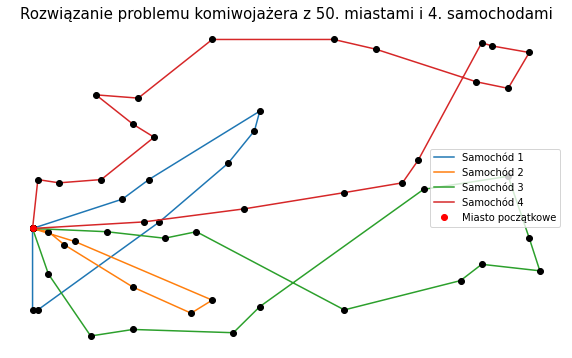

In [46]:
draw(Miasta, auta, solution)

Zmieniłam niektóre parametry, rozwiązanie byłoby dosyć okej gdyby nie te pętle - myśle, że oczekujemy bardziej wypukłych figur. Jednak też położenie punktu startowego pozostawia dużo do życzenia. 

# Badanie efektywności

Szukamy najlepszego fitnessu dla konkretnego przykładu

In [47]:
auta = 3
miasta = 15
Miasta = []
for i in range(miasta):
    Miasta.append([random.randint(0,100),random.randint(0,100)])
    
#wartosci w chromosomie
gene_space = range(1,(miasta - 1) * auta + 1)

num_genes = (miasta - 1) * auta

Ustawiam parametry, większe iteracje (liczbę pokoleń) bez fora niż w forze żeby miało sens, aby algorytm miał szansę znaleźć najoptymalniejsze rozwiązanie

In [48]:
fitness_function = fitness_func

#ile chromsomów w populacji
#ile genow ma chromosom
sol_per_pop = 50 #im cięższy problem - zwiększymy
num_genes = (miasta - 1) * auta #długość chromosomu - dla każdego auta segmenty miast

#ile wylaniamy rodzicow do "rozmanazania" (okolo 50% populacji)
#ile pokolen
#ilu rodzicow zachowac (kilka procent)
num_parents_mating = 25
num_generations = 1000 #im cięższy problem - zwiększymy
keep_parents = 2

#jaki typ selekcji rodzicow?
#sss = steady, rws=roulette, rank = rankingowa, tournament = turniejowa
parent_selection_type = "sss"

#w il =u punktach robic krzyzowanie?
crossover_type = "uniform"

#mutacja ma dzialac na ilu procent genow?
#trzeba pamietac ile genow ma chromosom
mutation_type = "random"
mutation_percent_genes = math.ceil(100/num_genes) #ma być jak najmniejsza możliwa

#inicjacja algorytmu z powyzszymi parametrami wpisanymi w atrybuty

Wywołuje algorytm poza pętlą, aby móc do niego przyrównywać. Hipotetycznie mam nadzieje, że to najlepsze rozwiązanie. 

Number of generations passed is 1000
Parameters of the best solution : [36. 31. 40. 26. 32.  6. 21. 22. 20. 37.  1.  3. 10.  2. 29. 42. 39. 38.
 35. 23. 28. 25. 34. 18. 24. 19. 41. 15. 27. 13.  9. 33.  8. 30.  4. 12.
 17. 14. 16.  5.  7. 11.]
Fitness value of the best solution = -498.7363251626347


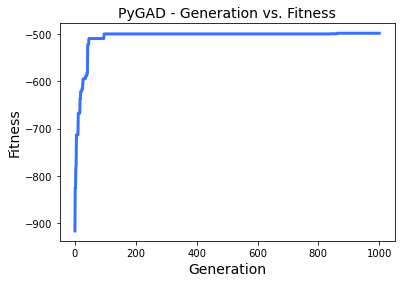

In [49]:
ga_instance = pygad.GA(gene_space=gene_space,
                       num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=PMX_crossover_func,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes,
                       allow_duplicate_genes=False)

#uruchomienie algorytmu

ga_instance.run()

#podsumowanie: najlepsze znalezione rozwiazanie (chromosom+ocena)
solution, solution_fitness, solution_idx = ga_instance.best_solution()

#ile generacji
print("Number of generations passed is {generations_completed}".format(generations_completed=ga_instance.generations_completed))

print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

#print("Predicted output based on the best solution : {prediction}".format(prediction=prediction))

#wyswietlenie wykresu: jak zmieniala sie ocena na przestrzeni pokolen
ga_instance.plot_fitness()

#zapamiętuje najlepszą wartość fitness
best_fitness = solution_fitness

[0, 6.0, 1.0, 3.0, 10.0, 2.0, 0]
[0, 0]
[0, 13.0, 9.0, 8.0, 4.0, 12.0, 14.0, 5.0, 7.0, 11.0, 0]


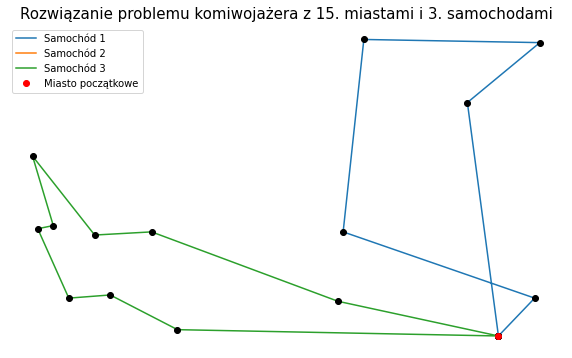

In [50]:
draw(Miasta, auta, solution)

Piszę funkcję, która działa jak stop criteria. Sprawdza ona czy fitness aktualnego rozwiązania jest lepszy bądź równy "optymalnemu" albo czy liczba pokoleń przeminiętych jest większa od 300. 

In [51]:
def stop_criteria1(ga_instance):
    if ga_instance.best_solution()[1] >= best_fitness:
        return "stop"
    if ga_instance.generations_completed >= 300:
        return "stop"

In [52]:
czasy = []
fitnesy = []
count = 0
n = 10
min_fitness = 10000000000
max_fitness = -10000000000
for i in range(n):
    start = time.time()
    ga_instance = pygad.GA(gene_space=gene_space,
                       num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=PMX_crossover_func,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes,
                       allow_duplicate_genes=False,
                       callback_generation = stop_criteria1)
    ga_instance.run()
    end = time.time()
    solution, solution_fitness, solution_idx = ga_instance.best_solution()
    if solution_fitness >= best_fitness:
        count += 1
    czasy.append(end - start)
    fitnesy.append(solution_fitness)
    if min_fitness > solution_fitness:
        min_fitness = solution_fitness
    if max_fitness < solution_fitness:
        max_fitness = solution_fitness
print("dokładność: ", count/n)
print("Średni czas działania: ", np.mean(czasy))
print("Średnia wartość fitness: ", np.mean(fitnesy))
print("Minimalny fitness: ", min_fitness)
print("Maksymalny fitness: ", max_fitness)

klasa_problemu.append("średni")
ilosc_miast.append(miasta)
ilosc_aut.append(auta)
sredni_czas_dzialania.append(round(np.mean(czasy),2))
minimalny_fitness.append(round(min_fitness,2))
sredni_fitness.append(round(np.mean(fitnesy),2))
maksymalny_fitness.append(round(max_fitness,2))
dokladnosc.append(count/n)
sposob_rozwiazania.append("AG z PMX")

/Users/zosiasiwiec/opt/anaconda3/lib/python3.10/site-packages/pygad/pygad.py:860: UserWarning: Starting from PyGAD 2.6.0, the callback_generation parameter is deprecated and will be removed in a later release of PyGAD. Please use the on_generation parameter instead.
  if not self.suppress_warnings: warnings.warn("Starting from PyGAD 2.6.0, the callback_generation parameter is deprecated and will be removed in a later release of PyGAD. Please use the on_generation parameter instead.")


dokładność:  0.7
Średni czas działania:  1.7590333223342896
Średnia wartość fitness:  -522.280712702698
Minimalny fitness:  -630.9900482211871
Maksymalny fitness:  -489.89583571798994


Teraz sprawdźmy dokładność bez PMX

In [53]:
czasy = []
fitnesy = []
count = 0
n = 10
min_fitness = 10000000000
max_fitness = -10000000000
for i in range(n):
    start = time.time()
    ga_instance = pygad.GA(gene_space=gene_space,
                       num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes,
                       allow_duplicate_genes=False,
                       callback_generation = stop_criteria1)
    ga_instance.run()
    end = time.time()
    solution, solution_fitness, solution_idx = ga_instance.best_solution()
    if solution_fitness >= best_fitness:
        count += 1
    czasy.append(end - start)
    fitnesy.append(solution_fitness)
    if min_fitness > solution_fitness:
        min_fitness = solution_fitness
    if max_fitness < solution_fitness:
        max_fitness = solution_fitness
print("dokładność: ", count/n)
print("Średni czas działania: ", np.mean(czasy))
print("Średnia wartość fitness: ", np.mean(fitnesy))
print("Minimalny fitness: ", min_fitness)
print("Maksymalny fitness: ", max_fitness)

klasa_problemu.append("średni")
ilosc_miast.append(miasta)
ilosc_aut.append(auta)
sredni_czas_dzialania.append(round(np.mean(czasy),2))
minimalny_fitness.append(round(min_fitness,2))
sredni_fitness.append(round(np.mean(fitnesy),2))
maksymalny_fitness.append(round(max_fitness,2))
dokladnosc.append(count/n)
sposob_rozwiazania.append("AG bez PMX")

dokładność:  0.6
Średni czas działania:  2.5539001703262327
Średnia wartość fitness:  -512.359282184889
Minimalny fitness:  -631.9353336194805
Maksymalny fitness:  -489.89583571798994


Zauważamy, że w tym przypadku PMX ma lepszą dokładność. Jak widzieliśmy na przykładach przeważnie tak jest, ale doza losowości czasami może płatać nam figle.

# Rozwiązanie za pomocą aco w fitness_func

In [30]:
# 5 miast 2 auta
auta = 2
miasta = 5
Miasta = []
for i in range(miasta):
    Miasta.append([random.randint(0,100),random.randint(0,100)])
    
from aco import AntColony

#teraz przypisujemy miasta autom, czyli w chromosomie moimi wartościami są numery aut
gene_space = range(auta)

def fitness_aco(solution, solution_idx):
    #zliczamy sumę odległości pomiędzy miastami dla każdego auta
    #na początku ustawiamy sumę na 0
    suma_odleglosci = 0
    drogi = []
    #dodaje puste listy dla każdego auta
    for i in range(auta):
        drogi.append([])
        
    #Patrząc na wartości w naszym solution, wpisujemy do naszych list aut wartości z poszczególnymi miastami
    for i in range(len(solution)):
        drogi[int(solution[i])].append(int(i + 1))
    
    #dla każdego auta osobno
    for droga in drogi:
        if len(droga) != 0:
            COORDS = []
            #dodajemy koordynaty miasta 0
            COORDS.append((Miasta[0][0],Miasta[0][1]))
            for i in droga:
                COORDS.append((Miasta[i][0],Miasta[i][1]))

            COORDS = tuple(COORDS)
            
            colony = AntColony(COORDS, ant_count= 20, alpha=0.5, beta=1.2, 
                        pheromone_evaporation_rate=0.80, pheromone_constant= 50.0,
                        iterations=10)
            
            #pobieramy optymalną ścieżkę
            optimal_nodes = colony.get_path()
        
            #wyliczamy odległość ścieżki
            for i in range(len(optimal_nodes) - 1):
                #odl między kolejnymi miastami
                odl = odleglosc(optimal_nodes[i], optimal_nodes[i+1])
                suma_odleglosci += odl
            #wracamy z ostatniego miasta do miasta 0
            suma_odleglosci += odleglosc(optimal_nodes[-1], optimal_nodes[0])
    return -suma_odleglosci

Bardzo małe parametry, bo runuję się bardzo długo = auta $\cdot$ sol_per_pop $\cdot$ iteracja w aco $\cdot$ liczba populacji

In [31]:
fitness_function = fitness_aco

#ile chromsomów w populacji
#ile genow ma chromosom
sol_per_pop = 20
num_genes = miasta -1

#ile wylaniamy rodzicow do "rozmanazania" (okolo 50% populacji)
#ile pokolen
#ilu rodzicow zachowac (kilka procent)
num_parents_mating = 5
num_generations = 25
keep_parents = 2

#jaki typ selekcji rodzicow?
#sss = steady, rws=roulette, rank = rankingowa, tournament = turniejowa
parent_selection_type = "sss"

#w il =u punktach robic krzyzowanie?
crossover_type = "uniform"

#mutacja ma dzialac na ilu procent genow?
#trzeba pamietac ile genow ma chromosom
mutation_type = "random"
mutation_percent_genes = math.ceil(100/num_genes)

#inicjacja algorytmu z powyzszymi parametrami wpisanymi w atrybuty

In [32]:
start = time.time()

ga_instance = pygad.GA(gene_space=gene_space,
                       num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes,
                       allow_duplicate_genes=True)

Tutaj nie możemy dać krzyżowania PMX, bo nie mamy unikalnych wartości w chromosomie

In [33]:
%%capture
#chowanie warningów
warnings.filterwarnings('ignore')


#uruchomienie algorytmu

ga_instance.run()

end = time.time()

In [34]:
print("czas działania algorytmu: ", end - start)

czas działania algorytmu:  406.5358648300171


In [35]:
%%capture

#podsumowanie: najlepsze znalezione rozwiazanie (chromosom+ocena)
solution, solution_fitness, solution_idx = ga_instance.best_solution()

#ile generacji
print("Number of generations passed is {generations_completed}".format(generations_completed=ga_instance.generations_completed))

print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

#print("Predicted output based on the best solution : {prediction}".format(prediction=prediction))

#wyswietlenie wykresu: jak zmieniala sie ocena na przestrzeni pokolen
ga_instance.plot_fitness()

Number of generations passed is 25
Parameters of the best solution : [0. 0. 0. 0.]
Fitness value of the best solution = -30.463092423455635


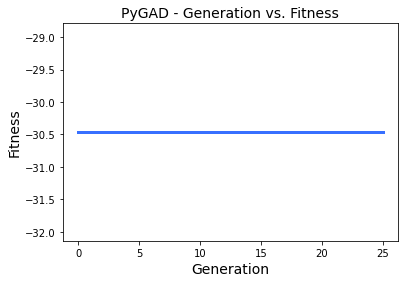

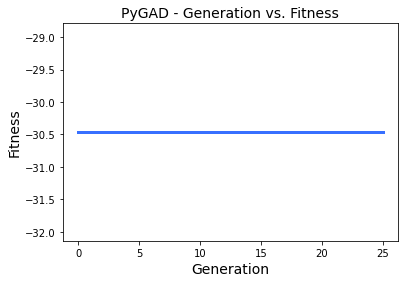

In [36]:
print("Number of generations passed is {generations_completed}".format(generations_completed=ga_instance.generations_completed))

print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

#wyswietlenie wykresu: jak zmieniala sie ocena na przestrzeni pokolen
ga_instance.plot_fitness()

iteration:  1
iteration:  2
iteration:  3
iteration:  4
iteration:  5
iteration:  6
iteration:  7
iteration:  8
iteration:  9
iteration:  10
iteration:  11
iteration:  12
iteration:  13
iteration:  14
iteration:  15
iteration:  16
iteration:  17
iteration:  18
iteration:  19
iteration:  20
iteration:  21
iteration:  22
iteration:  23
iteration:  24
iteration:  25
iteration:  26
iteration:  27
iteration:  28
iteration:  29
iteration:  30
iteration:  31
iteration:  32
iteration:  33
iteration:  34
iteration:  35
iteration:  36
iteration:  37
iteration:  38
iteration:  39
iteration:  40
iteration:  41
iteration:  42
iteration:  43
iteration:  44
iteration:  45
iteration:  46
iteration:  47
iteration:  48
iteration:  49
iteration:  50
iteration:  51
iteration:  52
iteration:  53
iteration:  54
iteration:  55
iteration:  56
iteration:  57
iteration:  58
iteration:  59
iteration:  60
iteration:  61
iteration:  62
iteration:  63
iteration:  64
iteration:  65
iteration:  66
iteration:  67
iter

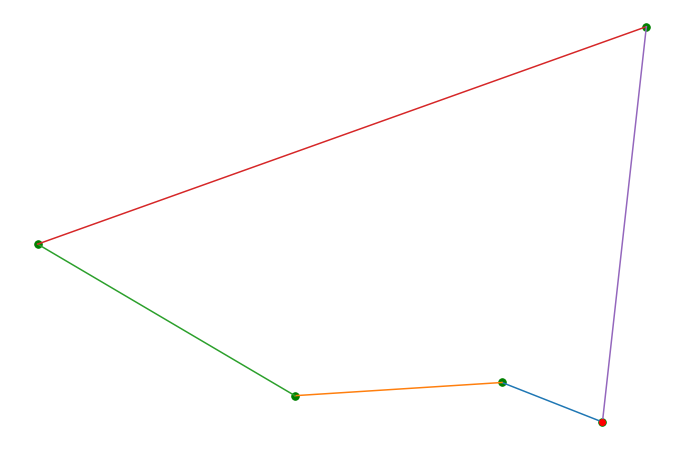

In [43]:
def plot_nodes(w=12, h=8):
    for x, y in Miasta:
        plt.plot(x, y, "g.", markersize=15)
    plt.axis("off")
    fig = plt.gcf()
    fig.set_size_inches([w, h])

def draw_aco(Towns, auta, solution):
    drogi = []
    #dodaje puste listy dla każdego auta
    for i in range(auta):
        drogi.append([])
        
    #Patrząc na wartości w naszym solution, wpisujemy do naszych list aut wartości z poszczególnymi miastami
    for i in range(len(solution)):
        drogi[int(solution[i])].append(int(i + 1))
        
    plot_nodes()
    
        
    #dla każdego auta osobno
    for droga in drogi:
        if len(droga) != 0:
            COORDS = []
            #dodajemy koordynaty miasta 0
            COORDS.append((Miasta[0][0],Miasta[0][1]))
            for i in droga:
                COORDS.append((Miasta[i][0],Miasta[i][1]))

            COORDS = tuple(COORDS)
            
            colony = AntColony(COORDS, ant_count= 100, alpha=0.5, beta=1.2, 
                        pheromone_evaporation_rate=0.80, pheromone_constant= 50.0,
                        iterations=600)
            
            #pobieramy optymalną ścieżkę
            optimal_nodes = colony.get_path()
            
            print(optimal_nodes)
            
            for i in range(len(optimal_nodes) - 1):
                plt.plot(
                    (optimal_nodes[i][0], optimal_nodes[i + 1][0]),
                    (optimal_nodes[i][1], optimal_nodes[i + 1][1]),
                    )
            plt.plot(
                    (optimal_nodes[-1][0], optimal_nodes[0][0]),
                    (optimal_nodes[-1][1], optimal_nodes[0][1]),
                    )
            plt.plot(optimal_nodes[0][0], optimal_nodes[0][1],'ro')
        
draw_aco(Miasta, auta, solution)


Rozwiązanie jest optymalne, jednak zajmuje ono za dużo czasu porównując do skali problemu. Nie wyobrażam sobie szukać za pomocą tego trudniejszego rozwiązania.

# Tworzymy tabelę rozwiązań

In [60]:
data = {
    'Klasa_problemu' : klasa_problemu,
    'Ilość_miast' : ilosc_miast,
    'Ilość_aut' : ilosc_aut,
    'Średni_czas_działania' : sredni_czas_dzialania,
    'Minimalny_fitness' : minimalny_fitness,
    'Średni_fitness' : sredni_fitness,
    'Maksymalny_fitness' : maksymalny_fitness,
    'Dokładność' : dokladnosc,
    'Sposób_rozwiązania' : sposob_rozwiazania
    }
df = pd.DataFrame(data)
df.index = [i+1 for i in range(len(df))]
df

,Klasa_problemu,Ilość_miast,Ilość_aut,Średni_czas_działania,Minimalny_fitness,Średni_fitness,Maksymalny_fitness,Dokładność,Sposób_rozwiązania
1,mały,5,2,0.46,-92.25,-92.25,-92.25,NaN,AG bez PMX
2,mały,5,2,0.32,-92.25,-92.25,-92.25,NaN,AG z PMX
3,mały,8,3,0.79,-247.83,-247.70,-244.95,NaN,AG z PMX
4,mały,10,5,2.41,-392.64,-365.71,-326.68,NaN,AG z PMX
5,średni,15,3,17.30,-459.04,-441.49,-359.85,NaN,AG bez PMX
6,średni,15,3,14.23,-574.37,-468.58,-443.76,NaN,AG z PMX
7,średni,12,4,15.04,-361.84,-345.82,-322.50,NaN,AG z PMX
8,średni,15,6,43.90,-476.89,-443.61,-394.43,NaN,AG z PMX
9,duży,25,5,101.54,-806.49,-611.63,-548.70,NaN,AG bez PMX
10,duży,25,5,109.84,-737.91,-636.23,-557.73,NaN,AG z PMX


Z tabeli możemy zauważyć, że algorytm genetyczny z PMX nie zawsze działa krócej. Pocieszające jest to, że jednak mimo wyciągania wartości średniej z fitness value to przy większych problemach jest ona bliżej lepszego rozwiązania. Osobiście uważam, że graficzne rozwiązania z PMx, były według mnie bardziej optymalne. Efektywność dobra, bardzo żałuję że nie mam dostępnego lepszego sprzętu aby przetestować większe liczby.